# GUI Evaluation Notebook
This notebook evaluates generated GUI prototypes (in HTML) against original GUI images (in JPG) using quantitative metrics.
We focus on similarity, visual layout comparison, and DOM complexity analysis.

In [1]:
import os
import json
import numpy as np
import pandas as pd
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from html2image import Html2Image
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

 # Configuration
Paths and evaluation settings.

In [5]:
original_path = "rico_guis"
generated_path = "generated_guis"

prompt_types = ["instruction", "pd_fs", "pd_zs", "ref_instruction"]

# Metric Functions
We define metrics including:
- **SSIM** for visual similarity.
- **DOM Complexity** via tag count.
- **Layout Area** by summing element bounding boxes (via inline style parsing).


In [31]:
def render_html_to_image(html_path, output_image_path):
    try:
        hti = Html2Image(output_path=os.path.dirname(output_image_path))
        hti.screenshot(
            html_file=html_path,
            save_as=os.path.basename(output_image_path),
            size=(375, 667)  # width x height
        )
        return output_image_path
    except Exception as e:
        print(f"Rendering error {html_path}: {e}")
        return None

def compute_ssim(image1_path, image2_path):
    try:
        img1 = Image.open(image1_path).convert("L").resize((256, 256))
        img2 = Image.open(image2_path).convert("L").resize((256, 256))
        ssim_val = ssim(np.array(img1), np.array(img2))
        return ssim_val
    except Exception as e:
        print(f"Error comparing {image1_path} and {image2_path}: {e}")
        return np.nan

def compute_dom_complexity(html_path):
    try:
        with open(html_path, "r", encoding="utf-8") as f:
            soup = BeautifulSoup(f, "html.parser")
        return len(soup.find_all())
    except Exception as e:
        print(f"Error parsing {html_path}: {e}")
        return np.nan

def json_find_bounds(obj):
    bounds_list = []
    if isinstance(obj, dict):
        for k, v in obj.items():
            if k == "bounds":
                x = v[0]
                y = v[1]
                w = v[2]
                h = v[3]
                bounds_list.append((x, y, x + w, y + h))
            else:
                bounds_list.extend(json_find_bounds(v))
    elif isinstance(obj, list):
        for item in obj:
            bounds_list.extend(json_find_bounds(item))
    return bounds_list

def html_find_bounds(html_path):
    try:
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        driver = webdriver.Chrome(options=chrome_options)
        driver.set_window_size(1440, 2560)
        driver.get(f"C:\\Users\Marija\IdeaProjects\gui-prototyping-analysis\\{html_path}")
        elements = driver.find_elements("css selector", "*")

        bounds_list = []
        for el in elements:
            rect = driver.execute_script("""
                var rect = arguments[0].getBoundingClientRect();
                return {left: rect.left, top: rect.top, width: rect.width, height: rect.height};
            """, el)
            if rect['width'] > 0 and rect['height'] > 0:
                x = rect["left"]
                y = rect["top"]
                w = rect["width"]
                h = rect["height"]
                bounds_list.append((x, y, x + w, y + h))

        driver.quit()
        return bounds_list

    except Exception as e:
        print(f"Error parsing {html_path}: {e}")
        return np.nan

def intersection_area(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    if x2 < x1 or y2 < y1:
        return 0
    return (x2 - x1) * (y2 - y1)

def extract_layout_area(json_path, html_path):
    if not os.path.exists(json_path):
        print(f"JSON does not exist {json_path}")
        return 0.0
    # try:
    #     with open(html_path, "r", encoding="utf-8") as f:
    #         html_elements = BeautifulSoup(f, "html.parser")
    # except Exception as e:
    #     print(f"Error parsing {html_path}: {e}")
    #     return np.nan

    try:
        with open(json_path, 'r') as f:
            data = json.load(f)

        original_boxes = []
        bounds = json_find_bounds(data)
        original_boxes.extend(bounds)

        generated_boxes = html_find_bounds(html_path)

        if not original_boxes or not generated_boxes:
            return 0.0

        total_intersection = 0
        total_area = sum((b[2] - b[0]) * (b[3] - b[1]) for b in original_boxes)

        for obox in original_boxes:
            for gbox in generated_boxes:
                total_intersection += intersection_area(obox, gbox)

        return total_intersection / total_area if total_area > 0 else 0.0

    except Exception as e:
        print(f"Error parsing {json_path}: {e}")
        return 0.0

# Run Evaluation
Iterate through all GUI samples and compute metrics.

In [ ]:
results = []

for gui_id in os.listdir(original_path):
    if not gui_id.endswith(".jpg") or not os.path.join(generated_path, gui_num):
        continue
    gui_num = gui_id.split(".")[0]
    original_img_path = os.path.join(original_path, gui_id)
    original_json_path = os.path.join(original_path, f"{gui_num}.json")

    for prompt in prompt_types:
        html_path = os.path.join(generated_path, gui_num, f"{prompt}.html")
        html_img_path = os.path.join(generated_path, gui_num, f"{prompt}.png")

        dom_complexity = compute_dom_complexity(html_path)
        layout_area = extract_layout_area(original_json_path, html_path)
        rendered_img_path = render_html_to_image(html_path, html_img_path)
        ssim_score = compute_ssim(original_img_path, rendered_img_path)

        results.append({
            "GUI_ID": gui_num,
            "Prompt": prompt,
            "DOM_Complexity": dom_complexity,
            "Layout_Area": layout_area,
            "SSIM_Score": ssim_score
        })

df = pd.DataFrame(results)
# df.head()
df

In [32]:
for gui_id in os.listdir(generated_path):
    gui_num = gui_id.split(".")[0]

    for prompt in prompt_types:
        html_path = os.path.join(generated_path, gui_num, f"{prompt}.html")
        html_img_path = os.path.join(generated_path, gui_num, f"{prompt}.png")

        if os.path.isfile(html_path):
            rendered_img_path = render_html_to_image(html_path, html_img_path)
            print("generirana slika:", rendered_img_path)

generirana slika: generated_guis\18782\instruction.png
generirana slika: generated_guis\18782\pd_fs.png
generirana slika: generated_guis\18782\pd_zs.png
generirana slika: generated_guis\18782\ref_instruction.png
generirana slika: generated_guis\18784\instruction.png
generirana slika: generated_guis\18784\pd_fs.png
generirana slika: generated_guis\18784\pd_zs.png
generirana slika: generated_guis\18784\ref_instruction.png
generirana slika: generated_guis\22151\instruction.png
generirana slika: generated_guis\22151\pd_fs.png
generirana slika: generated_guis\22151\pd_zs.png
generirana slika: generated_guis\22151\ref_instruction.png
generirana slika: generated_guis\30982\instruction.png
generirana slika: generated_guis\30982\pd_fs.png
generirana slika: generated_guis\30982\pd_zs.png
generirana slika: generated_guis\30982\ref_instruction.png
generirana slika: generated_guis\3261\instruction.png
generirana slika: generated_guis\3261\pd_fs.png
generirana slika: generated_guis\3261\pd_zs.png
ge

In [ ]:
for gui_id in os.listdir(generated_path):
    gui_num = gui_id.split(".")[0]
    print(os.path.join(generated_path, gui_num))

In [35]:
import pandas as pd

# Najprej povprečimo metrike čez vse promte za isti GUI_ID
df_grouped = df.groupby("GUI_ID").agg({
    "DOM_Complexity": "mean",
    "Layout_Area": "mean",
    "SSIM_Score": "mean"
}).reset_index()

# Normalizacija - deli z max vrednostjo v posamezni metriki
for col in ["DOM_Complexity", "Layout_Area", "SSIM_Score"]:
    df_grouped[f"{col}_norm"] = df_grouped[col] / df_grouped[col].max()

# Top 10 po posamezni metriki
top10_dom = df_grouped.nlargest(10, "DOM_Complexity_norm")[["GUI_ID", "DOM_Complexity_norm"]]
top10_layout = df_grouped.nlargest(10, "Layout_Area_norm")[["GUI_ID", "Layout_Area_norm"]]
top10_ssim = df_grouped.nlargest(10, "SSIM_Score_norm")[["GUI_ID", "SSIM_Score_norm"]]

# Skupna ocena = povprečje normaliziranih metrik
df_grouped["Overall_score"] = df_grouped[["DOM_Complexity_norm", "Layout_Area_norm", "SSIM_Score_norm"]].mean(axis=1)

# Top 5 glede na vse metrike
top5_overall = df_grouped.nlargest(5, "Overall_score")[["GUI_ID", "Overall_score", "DOM_Complexity_norm", "Layout_Area_norm", "SSIM_Score_norm"]]

# Rezultati
print("Top 10 DOM:")
print(top10_dom)
print("\nTop 10 Layout:")
print(top10_layout)
print("\nTop 10 SSIM:")
print(top10_ssim)
print("\nTop 5 Overall:")
print(top5_overall)

Top 10 DOM:
   GUI_ID  DOM_Complexity_norm
15  67044             1.000000
5   34346             0.955882
7   38961             0.906863
1   18784             0.838235
13  63575             0.828431
17  69587             0.813725
3   30982             0.784314
12  59370             0.784314
4    3261             0.730392
0   18782             0.691176

Top 10 Layout:
   GUI_ID  Layout_Area_norm
4    3261          1.000000
11  54377          0.936178
15  67044          0.612659
16  67045          0.542466
18   9007          0.452350
17  69587          0.433180
0   18782          0.422446
13  63575          0.346178
2   22151          0.325479
12  59370          0.296309

Top 10 SSIM:
   GUI_ID  SSIM_Score_norm
11  54377         1.000000
5   34346         0.736718
10  53054         0.652607
6   34527         0.648571
7   38961         0.644231
12  59370         0.633640
15  67044         0.629270
2   22151         0.627555
4    3261         0.583165
17  69587         0.574624

Top 5 Overa

# Visualize Metrics

<Figure size 1200x600 with 0 Axes>

<Figure size 640x480 with 0 Axes>

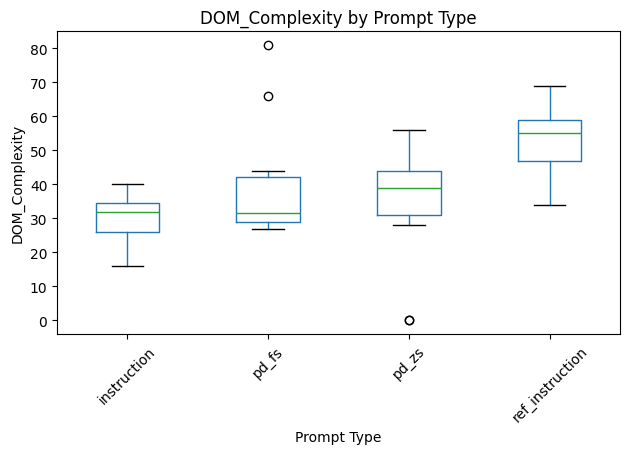

<Figure size 640x480 with 0 Axes>

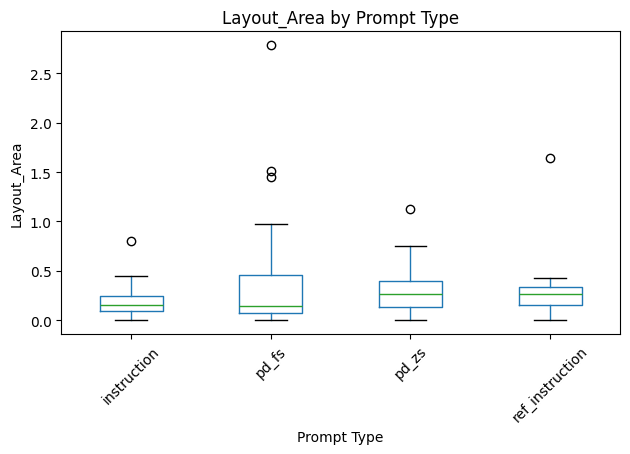

<Figure size 640x480 with 0 Axes>

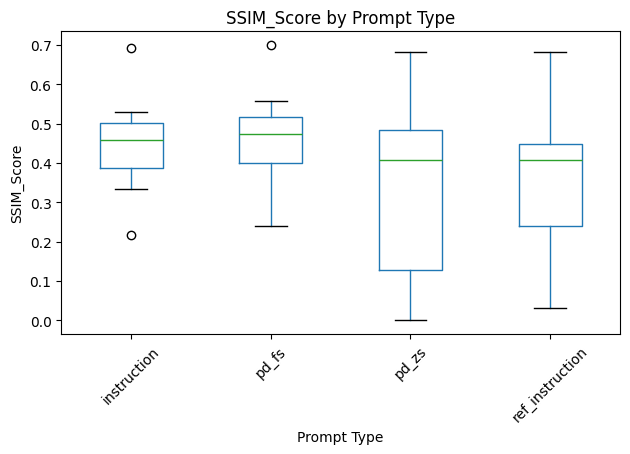

In [36]:
plt.figure(figsize=(12, 6))
for metric in ["DOM_Complexity", "Layout_Area", "SSIM_Score"]:
    plt.figure()
    df.boxplot(column=metric, by="Prompt", grid=False)
    plt.title(f"{metric} by Prompt Type")
    plt.suptitle("")
    plt.ylabel(metric)
    plt.xlabel("Prompt Type")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Summary Table

In [37]:
summary = df.groupby("Prompt")[["DOM_Complexity", "Layout_Area", "SSIM_Score"]].mean().round(2)
summary

,DOM_Complexity,Layout_Area,SSIM_Score
Prompt,,,
instruction,30.60,0.20,0.45
pd_fs,38.64,0.46,0.46
pd_zs,33.92,0.29,0.34
ref_instruction,52.71,0.30,0.34
